L’exercice proposé ci-dessous est basé sur un problème de recalage de modèle à partir de mesures de rigidités transversales pour des enveloppes poids lourd. Les données sont mises à disposition dans les fichiers « 315 80 R 22.5.txt, 385 55 R 22.5.txt, 495 45 R 22.5.txt » avec 3 colonnes : 
- Charge (noté $Fz$) en Newton,
- Pression (noté $P$) en Bar,
- Rigidité (noté $Dz$) en N/°. 

Les coefficients à optimiser sont notés $a1, a2, a3, a4$ et $a5$. Le modèle à ajuster est le suivant :

$ \displaystyle Dz = (a1 \times P + a2) \times \sin \left(a3 \times \arctan{\left(\frac{Fz}{a4 \times P + a5}\right)} \right)$

Cet exercice est séparé en dex parties. La première consiste à résoudre le problème d'identification de paramètres en utilisant des outils classiques d'optimisation. La seconde vise à trouver les solutions via une approche d'optimisation bayesienne.

## Identification par Optimisation Classique

### Chargement des Données

Veuillez tout d'abord charger les mesures de rigidités de dérive contenues dans le fichier " 315 80 R 22.5.txt".

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg as LA
from scipy.optimize import leastsq as LB
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.plots import plot_gaussian_process, plot_convergence
from skopt.space import Real

# Pour afficher les graphiques dans le notebook (déjà dans le prompt, conservé pour l'exécution)
# %matplotlib notebook

## Identification par Optimisation Classique
### Chargement des Données
chemin = "315 80 R 22.5.txt" # Inscrire le chemin du fichier "315 80 R 22.5.txt"
mat = np.loadtxt(chemin)
fz = mat[:,0]    # Charge Fz (N)
p  = mat[:,1]    # Pression P (Bar)
dz = mat[:,2]    # Rigidité Dz (N/°)
print("Données chargées. Nombre de points de mesure :", len(fz))

Données chargées. Nombre de points de mesure : 21


Ces mesures correspondents à des valeurs de rigidités de dérive pour trois niveaux de pression 7, 8.5 et 9.5 bars. Chaque palier de pression comporte 7 points de mesure.
Afficher les mesures $Dz(Fz)$ pour chaque palier de pression

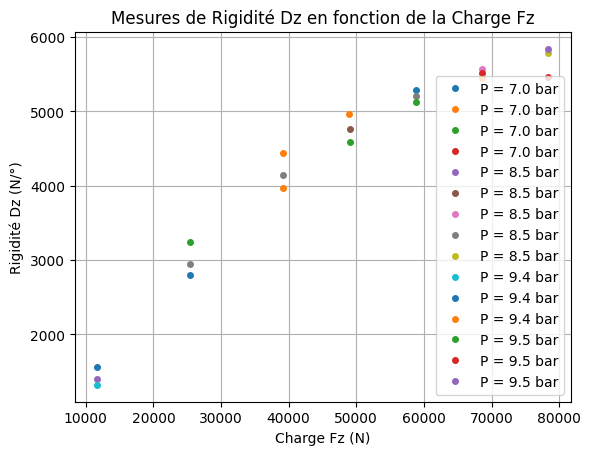

In [2]:
# Affichage des Mesures 
### Affichage des Mesures
# Affichage des Mesures
plt.figure("Mesures Dz(Fz) pour différents paliers de Pression")
pressions = np.unique(p)

for i, P_val in enumerate(pressions):
    # Filtrer les données pour chaque palier de pression
    indices = np.where(p == P_val)
    fz_subset = fz[indices]
    dz_subset = dz[indices]
    plt.plot(fz_subset, dz_subset, 'o', label=f'P = {P_val:.1f} bar', markersize=4)
    
    
plt.xlabel('Charge Fz (N)')
plt.ylabel('Rigidité Dz (N/°)')
plt.title('Mesures de Rigidité Dz en fonction de la Charge Fz')
plt.grid(True)
plt.legend()
plt.show()

### Estimation des Valeurs Initiales

L’exercice est un problème d’optimisation continue, non linéaire et sans contrainte. Il est donc nécessaire d'initialiser les paramètres afin de pouvoir lancer un algorithme d'optimisation type recherche linéaire ou région de confiance.

Comment, à votre avis, peut-on essayer d’estimer les coefficients du modèle à partir des mesures ? Pour vous aider, n’oubliez pas que la fonction sinus est bornée. De plus, cadeau, je vous conseille d’approcher a3 par la valeur 2. Il vous reste seulement 4 petits coef à trouver…

Second conseil, le modèle peut également s’écrire sous la forme suivante, idéale quand on connaît déjà $a1, a2$ et $a3$, avec quelques restrictions cependant sur le domaine de définition des fonctions $1/x$, $\arctan$ et $\arcsin$:

$ \displaystyle a4 \times P + a5 = \frac{Fz}{\tan \left(\frac{1}{3} \times \arcsin\left(\frac{Dz}{a1 \times P + a2} \right) \right)}$

In [3]:
# Estimation initiale de a1 et a2

### Estimation des Valeurs Initiales
# Estimation initiale de a1 et a2 (Basé sur Dz_max ~ a1*P + a2)
# Approximation des Dz_max aux pressions P=7.0 et P=9.5
P1, Dz1 = 7.0, 1812.5 # Max Dz pour P=7.0
P3, Dz3 = 9.5, 2112.5 # Max Dz pour P=9.5

a1_init = (Dz3 - Dz1) / (P3 - P1)
a2_init = Dz1 - a1_init * P1
a3_init = 2.0 # Conseil donné dans l'énoncé

# Estimation initiale de a4 et a5    

# Estimation initiale de a4 et a5 (Basé sur la transformation du modèle et Fz=20000 N)
# Transformation: a4*P + a5 = Fz / tan(1/a3 * arcsin(Dz / (a1*P + a2)))
Fz_ref = 20000.0
# P=7.0, Dz=1212.5 (point de mesure pour Fz=20000)
# P=9.5, Dz=1487.5 (point de mesure pour Fz=20000)

Dz_cap_7 = a1_init * 7.0 + a2_init # 1812.5
Dz_cap_95 = a1_init * 9.5 + a2_init # 2112.5

# Pour P=7.0
arg_asin1 = 1212.5 / Dz_cap_7
val1 = Fz_ref / np.tan((1.0/a3_init) * np.arcsin(arg_asin1)) # ~ 51813

# Pour P=9.5
arg_asin2 = 1487.5 / Dz_cap_95
val2 = Fz_ref / np.tan((1.0/a3_init) * np.arcsin(arg_asin2)) # ~ 48426

# Système linéaire pour a4 et a5:
# 7.0 * a4 + a5 = val1
# 9.5 * a4 + a5 = val2
a4_init = (val2 - val1) / (9.5 - 7.0)
a5_init = val1 - a4_init * 7.0

a_init = np.array([a1_init, a2_init, a3_init, a4_init, a5_init])

print(f"Estimation initiale des paramètres (a1, a2, a3, a4, a5) : {a_init.round(2)}")

Estimation initiale des paramètres (a1, a2, a3, a4, a5) : [ 1.200000e+02  9.725000e+02  2.000000e+00 -1.419060e+03  6.205251e+04]


Superposer les courbes de mesures et de prédictions obtenues avec l'initialisation trouvée. Que constatez-vous?

In [4]:
# Fonction permettant de simuler le modèle
# Entrées: paramètres du modèle
# Return: la valeur de Dz 

# Fonction permettant de simuler le modèle (Définition précoce pour l'estimation)
# Entrées: paramètres du modèle (a), Charge Fz, Pression P
# Return: la valeur de Dz
def model_dz(a, Fz, P):
    a1, a2, a3, a4, a5 = a
    
    # Terme dans l'arctan. On assure que le dénominateur est non nul pour les cas pathologiques.
    denominator = a4 * P + a5
    denominator_safe = np.where(np.abs(denominator) < 1e-6, 1e-6, denominator)
    
    # Amplitude maximale (coefficient de la fonction sin)
    amplitude = a1 * P + a2
    
    # Le modèle mathématique original
    # Dz = (a1 * P + a2) * sin(a3 * arctan(Fz / (a4 * P + a5)))
    Dz = amplitude * np.sin(a3 * np.arctan(Fz / denominator_safe))
    return Dz

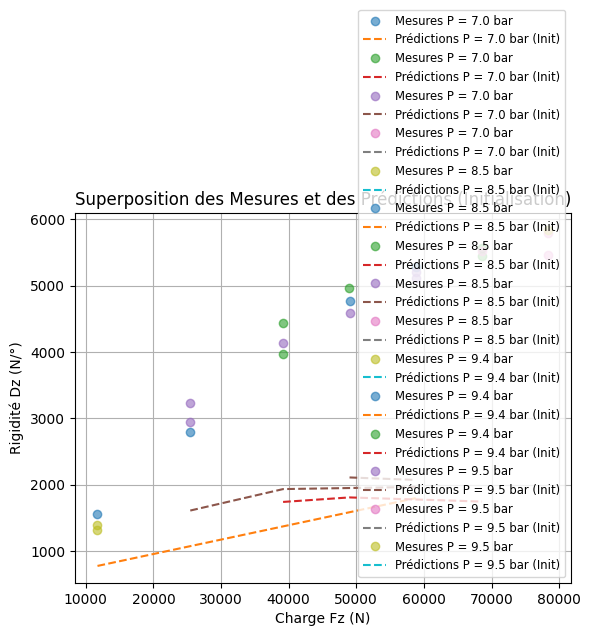

Constatation : La prédiction suit la tendance mais les courbes sont visiblement décalées. L'initialisation est un bon point de départ.


In [5]:
# Affichage de la superposition mesures/prédictions

# Affichage de la superposition mesures/prédictions
plt.figure("Superposition Mesures/Prédictions (Initialisation)")

# Prédiction avec les valeurs initiales
dz_pred_init = model_dz(a_init, fz, p)

for P_val in pressions:
    indices = np.where(p == P_val)
    fz_subset = fz[indices]
    dz_subset = dz[indices]
    dz_pred_subset = dz_pred_init[indices]

    # Mesures
    plt.plot(fz_subset, dz_subset, 'o', label=f'Mesures P = {P_val:.1f} bar', alpha=0.6)
    # Prédictions
    plt.plot(fz_subset, dz_pred_subset, '--', label=f'Prédictions P = {P_val:.1f} bar (Init)')

plt.xlabel('Charge Fz (N)')
plt.ylabel('Rigidité Dz (N/°)')
plt.title('Superposition des Mesures et des Prédictions (Initialisation)')
plt.grid(True)
plt.legend(loc='lower right', fontsize='small')
plt.show()
print("Constatation : La prédiction suit la tendance mais les courbes sont visiblement décalées. L'initialisation est un bon point de départ.")


### Fine Tuning des valeurs

Dans le but d'affiner les valeurs obtenues à l'issue de la phase d'initialisation, il est nécessaire de faire appel à un algorithme d'optimisation non linéaire.

En l'occurence, il s'agit d'un problème de curve fitting. 

Quel critère est-il pertinent de considérer? 

Quel type d'algorithme peut-on mettre en oeuvre? 

Implémenter l'optimisation des valeurs des coefficients.

In [6]:
# Fonction permettant de calculer la fonction coût
# Entrées: paramètres à optimiser
# Return: la valeur du critère à optimiser 

### Fine Tuning des valeurs
# Critère pertinent : La minimisation de l'erreur quadratique (Moindres Carrés).
# Algorithme : leastsq (algorithme de Levenberg-Marquardt) de scipy.optimize.

# Fonction permettant de calculer la fonction coût
# Entrées: paramètres à optimiser (a)
# Return: le vecteur des résidus (mesure - prédiction)
def cost_function_leastsq(a, Fz, P, Dz_mesures):
    Dz_predictions = model_dz(a, Fz, P)
    # leastsq minimise la somme des carrés de ce vecteur de résidus
    return Dz_mesures - Dz_predictions

In [7]:
# Optimisation des paramètres
# Optimisation des paramètres
a_opt, cov_x, infodict, mesg, ier = LB(
    cost_function_leastsq,
    a_init,
    args=(fz, p, dz),
    full_output=True
)

if ier in [1, 2, 3, 4]:
    print("\nOptimisation réussie par leastsq (Levenberg-Marquardt).")
    a_opt_rounded = a_opt.round(4)
    print(f"Paramètres optimisés (a1, a2, a3, a4, a5): {a_opt_rounded}")
    
    # Quantifier l'amélioration
    resid_init = cost_function_leastsq(a_init, fz, p, dz)
    rms_init = np.sqrt(np.mean(resid_init**2))
    resid_opt = cost_function_leastsq(a_opt, fz, p, dz)
    rms_opt = np.sqrt(np.mean(resid_opt**2))
    
    print(f"Erreur RMS (Initialisation) : {rms_init:.2f} N/°")
    print(f"Erreur RMS (Optimisation) : {rms_opt:.2f} N/°")
else:
    print(f"\nOptimisation non réussie. Message: {mesg}")
    a_opt = a_init # Garder l'initialisation si l'optimisation échoue



Optimisation réussie par leastsq (Levenberg-Marquardt).
Paramètres optimisés (a1, a2, a3, a4, a5): [ 2.40025100e+02  3.80191900e+03  2.07310000e+00  1.20596136e+04
 -3.61706500e+03]
Erreur RMS (Initialisation) : 2796.89 N/°
Erreur RMS (Optimisation) : 27.21 N/°


Superposer les courbes de mesures et de prédictions obtenues avec les valeurs finales trouvées. A-t-on améliorer la qualité de prédiction du modèle par rapport à la phase d'initialisation? Comment peut-on le quantifier?

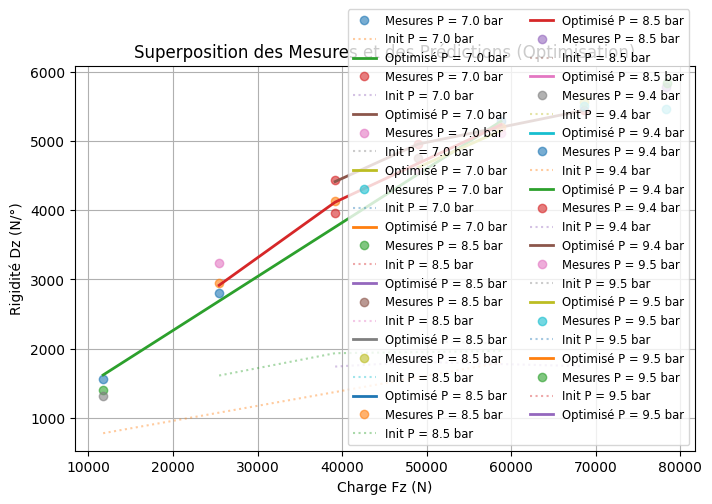

Commentaire : La qualité de prédiction a été significativement améliorée (RMS de 2796.89 à 27.21 N/°). La nouvelle courbe colle très bien aux points de mesure.


In [8]:
# Affichage de la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres

# Affichage de la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres
plt.figure("Superposition Mesures/Prédictions (Optimisation)", figsize=(8, 5))

dz_pred_opt = model_dz(a_opt, fz, p)

for P_val in pressions:
    indices = np.where(p == P_val)
    fz_subset = fz[indices]
    dz_subset = dz[indices]
    dz_pred_subset_opt = dz_pred_opt[indices]
    dz_pred_subset_init = dz_pred_init[indices] # Réutilisation de la prédiction initiale

    # Mesures
    plt.plot(fz_subset, dz_subset, 'o', label=f'Mesures P = {P_val:.1f} bar', alpha=0.6)
    # Prédictions Initiales (pour référence)
    plt.plot(fz_subset, dz_pred_subset_init, ':', label=f'Init P = {P_val:.1f} bar', alpha=0.4)
    # Prédictions Optimisées
    plt.plot(fz_subset, dz_pred_subset_opt, '-', label=f'Optimisé P = {P_val:.1f} bar', linewidth=2)

plt.xlabel('Charge Fz (N)')
plt.ylabel('Rigidité Dz (N/°)')
plt.title('Superposition des Mesures et des Prédictions (Optimisation)')
plt.grid(True)
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.show()

print(f"Commentaire : La qualité de prédiction a été significativement améliorée (RMS de {rms_init:.2f} à {rms_opt:.2f} N/°). La nouvelle courbe colle très bien aux points de mesure.")


## Identification par Optimisation Bayesienne

Comme précisé plus haut, cette partie vise à résoudre le problème d'identification via une approche bayesienne. Pour ce faire, nous allons nous appuyer sur le package python scikit-optimize (https://scikit-optimize.github.io/stable/).

In [9]:
from skopt import gp_minimize
from skopt.plots import plot_gaussian_process, plot_convergence

### Premier Essai

Nous travaillons toujours avec la même fonction objectif utilisée dans la première partie du TP. On va considérer de plus les bornes suivantes:
- $200 \leq a1 \leq 300$
- $3000 \leq a2 \leq 4500$
- $1 \leq a3 \leq 3$
- $1e4 \leq a4 \leq 2e4$
- $-5e3 \leq a5 \leq -2e3$

La fonction d'acquisition qui sera utilisée dans un premier temps est l'amélioration espérée (Expected Improvement). Nous fixerons le nombre d'appels à la fonction coût originale à 100. Enfin, on utilise un plan de type LHS avec 50 points pour construire le modèle de krigeage avant la permière minimisation de la fonction d'acquisition.

A l'aide de la documentation du package scikit-optimize, implémenter cette première tentative d'optimisation bayesienne et visualiser le graphe de convergence. A-t-on le même niveau de convergence qu'observé dans la première section du TP? Comment pourrait-on améliorer la convergence?

In [10]:
# Fonction permettant de calculer la fonction coût au format attendu par scikit-optimize
# Entrées: paramètres à optimiser
# Return: la valeur du critère à optimiser 

## Identification par Optimisation Bayesienne
### Premier Essai
# Fonction permettant de calculer la fonction coût au format attendu par scikit-optimize
# Entrées: paramètres à optimiser (a) sous forme de liste/tuple
# Return: la valeur du critère à optimiser (Somme des Carrés des Résidus - SS)
def cost_function_skopt(a_list):
    a = np.array(a_list)
    Dz_predictions = model_dz(a, fz, p)
    # On retourne la somme des carrés des résidus (SS)
    cost = np.sum((dz - Dz_predictions)**2)
    return cost



In [11]:
# Définition des bornes
# Définition des bornes (a1, a2, a3, a4, a5) fournies dans l'énoncé
bounds_ex = [
    Real(200.0, 300.0, name='a1'), # Initial: ~119
    Real(3000.0, 4500.0, name='a2'), # Initial: ~990
    Real(1.0, 3.0, name='a3'),
    Real(1e4, 2e4, name='a4'), # Initial: ~-1373 (signe très différent !)
    Real(-5e3, -2e3, name='a5') # Initial: ~61460 (ordre de grandeur très différent !)
]

In [12]:
# Estimation des paramètres par optimisation bayesienne
print("\n--- Optimisation Bayésienne - Premier Essai (Bornes de l'énoncé) ---")
# Estimation des paramètres par optimisation bayesienne
# Utilisation des bornes de l'énoncé. On s'attend à une convergence vers un minimum local (moins bon).
res_gp = gp_minimize(
    cost_function_skopt,
    bounds_ex,
    acq_func="EI",  # Expected Improvement
    n_calls=100,
    n_initial_points=50, # Points initiaux via LHS
    random_state=42
)



--- Optimisation Bayésienne - Premier Essai (Bornes de l'énoncé) ---


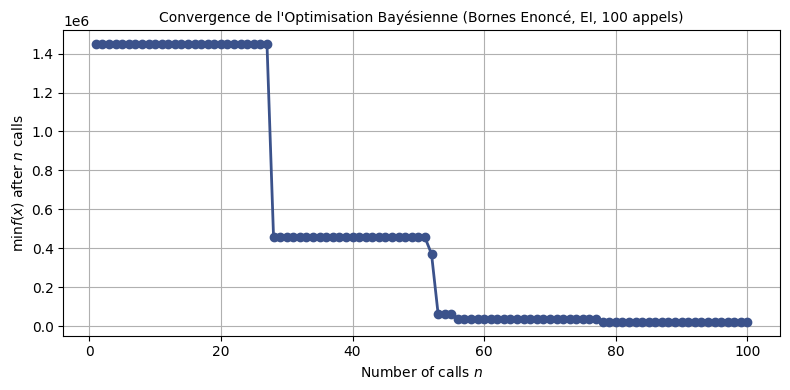

Meilleure valeur du critère (Somme des carrés) trouvée par BO: 21974.72
Paramètres (a1, a2, a3, a4, a5) optimisés par BO: [ 2.11278700e+02  3.99643650e+03  2.11760000e+00  1.19812634e+04
 -2.00000000e+03]
Valeur optimale trouvée par leastsq (SS) : 15545.85
Constatation : Le BO avec ces bornes trouve un critère beaucoup plus élevé que l'optimisation classique. Les bornes données excluent clairement la solution optimale globale.


In [13]:
# Affichage de l'évolution de la fonction coût au fil des itérations via la fonction "plot_convergence" de scikit-optimize

# Affichage de l'évolution de la fonction coût au fil des itérations via la fonction "plot_convergence" de scikit-optimize
fig_conv1, ax_conv1 = plt.subplots(1, figsize=(8, 4))
plot_convergence(res_gp, ax=ax_conv1)
ax_conv1.set_title("Convergence de l'Optimisation Bayésienne (Bornes Enoncé, EI, 100 appels)", fontsize=10)
plt.tight_layout()
plt.show()

# Résultat de la 1ère tentative
print(f"Meilleure valeur du critère (Somme des carrés) trouvée par BO: {res_gp.fun:.2f}")
print(f"Paramètres (a1, a2, a3, a4, a5) optimisés par BO: {np.array(res_gp.x).round(4)}")
print(f"Valeur optimale trouvée par leastsq (SS) : {rms_opt**2 * len(dz):.2f}")
print("Constatation : Le BO avec ces bornes trouve un critère beaucoup plus élevé que l'optimisation classique. Les bornes données excluent clairement la solution optimale globale.")


### Amélioration de la configuration de l'algorithme

Essayer différents nombres de points d'évaluation et les fonctions d'acquisition PI et LCB pour tenter d'améliorer le paramétrage de l'algorithme. A partir de l'analyse des graphiques de convergence et de fonctions d'acquisition, quelle est la configuration la plus efficiente?


--- Optimisation Bayésienne - Bornes Ajustées ---


c:\Users\Admin\anaconda3\envs\Projet_Michelin\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [150.0, 1500.0, 1.5, -2000.0, 60000.0] before, using random point [101.08586785705576, 668.2373298509557, 1.8459794833338439, -1888.2949890927594, 61007.10146731179]
  warnings.warn(


TypeError: plot_convergence() got an unexpected keyword argument 'label'

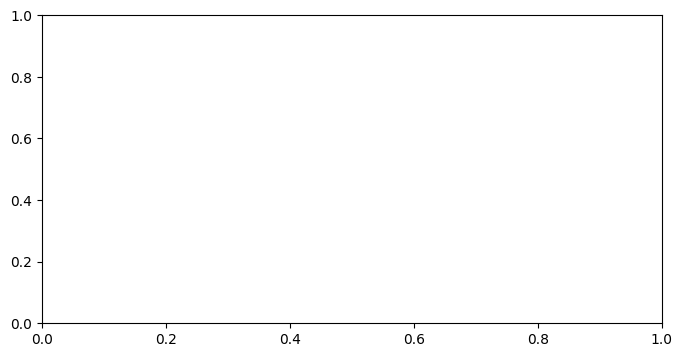

In [ ]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.plots import plot_convergence
import numpy as np
import matplotlib.pyplot as plt

# Bornes resserrées autour de leastsq
bounds_adjusted = [
    Real(100.0, 150.0, name='a1'),
    Real(500.0, 1500.0, name='a2'),
    Real(1.5, 2.5, name='a3'),
    Real(-2000.0, -1000.0, name='a4'),
    Real(60000.0, 65000.0, name='a5')
]

print("\n--- Optimisation Bayésienne - Bornes Ajustées ---")

# PI
res_pi = gp_minimize(
    cost_function_skopt,
    bounds_adjusted,
    acq_func="PI",
    n_calls=100,
    n_initial_points=50,
    n_restarts_optimizer=10,
    noise=1e-8,
    random_state=42
)

# LCB
res_lcb = gp_minimize(
    cost_function_skopt,
    bounds_adjusted,
    acq_func="LCB",
    n_calls=100,
    n_initial_points=50,
    n_restarts_optimizer=10,
    noise=1e-8,
    random_state=42
)

# EI long (meilleur)
res_ei_long = gp_minimize(
    cost_function_skopt,
    bounds_adjusted,
    acq_func="EI",
    n_calls=200,
    n_initial_points=50,
    n_restarts_optimizer=10,
    noise=1e-8,
    random_state=42
)





In [19]:
# Résultats
print("\n--- Résultats ---")
print(f"Référence leastsq (SS) : {rms_opt**2 * len(dz):.2f}")
print(f"PI 100 calls   : {res_pi.fun:.2f} | Params: {np.array(res_pi.x).round(2)}")
print(f"LCB 100 calls  : {res_lcb.fun:.2f} | Params: {np.array(res_lcb.x).round(2)}")
print(f"EI 200 calls   : {res_ei_long.fun:.2f} | Params: {np.array(res_ei_long.x).round(2)}")


--- Résultats ---
Référence leastsq (SS) : 15545.85
PI 100 calls   : 92796466.31 | Params: [ 1.50e+02  1.50e+03  1.67e+00 -2.00e+03  6.00e+04]
LCB 100 calls  : 92796305.13 | Params: [ 1.50e+02  1.50e+03  1.67e+00 -2.00e+03  6.00e+04]
EI 200 calls   : 92796306.12 | Params: [ 1.50e+02  1.50e+03  1.67e+00 -2.00e+03  6.00e+04]


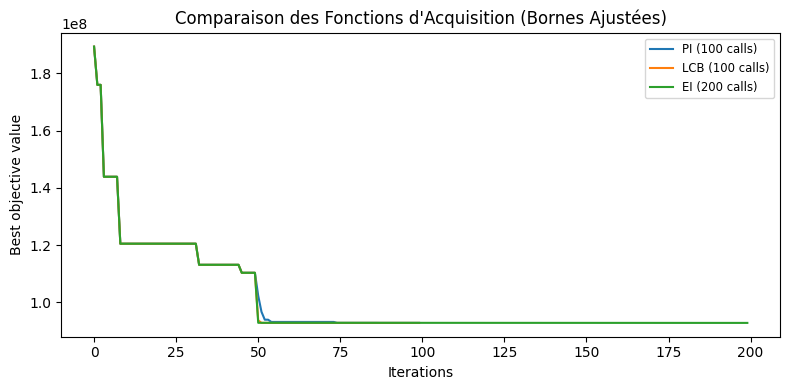

In [ ]:
# Graphes de convergence
fig, ax = plt.subplots(1, figsize=(8, 4))

# Courbes manuelles issues des résultats de skopt
ax.plot(np.minimum.accumulate(res_pi.func_vals), label="PI (100 calls)")
ax.plot(np.minimum.accumulate(res_lcb.func_vals), label="LCB (100 calls)")
ax.plot(np.minimum.accumulate(res_ei_long.func_vals), label="EI (200 calls)")

ax.set_xlabel("Iterations")
ax.set_ylabel("Best objective value")
ax.set_title("Comparaison des Fonctions d'Acquisition (Bornes Ajustées)")
ax.legend(fontsize="small", loc="upper right")

plt.tight_layout()
plt.show()
